# Project D4: UFO Sightings

* Dataset 1 (6 MB): UFO Sightings dataset by Willian Oliveira Gibin [1]
* Dataset 1 (11 MB): UFO Sightings dataset by National UFO reporting Center (NUFORC) [2]

Goals:
1.   Are UFO sightings still relevant? Analyze sightings frequency over time
2.   Predict new possible UFO sightings place and time
3.   Predict how the sighting will look like when experiencing it. How long it lasted and how the UFO looked like?

Links:

[1] https://www.kaggle.com/datasets/willianoliveiragibin/ufo-sightings
[2] https://www.kaggle.com/datasets/NUFORC/ufo-sightings

Project repository: https://github.com/RaunoValo/IDS_D4

TEAM:
Iris Kreinin,
Raiko Valo,
Rauno Valo

## Google Drive Colab Notebooks mounting

In [1]:
# from google.colab import drive

# # Haagime külge GD kausta - tuleb omalt poolt anda Colabile juurdepääsuluba
# drive.mount('/content/drive')
# # Failidega tegutsemiseks liigume GD kausta Colab Notebooks (või mujale, muutke endale sobivaks)
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Andmeteadus/D4_UFO')

In [2]:
from google.colab import drive

# Haagime külge GD kausta - tuleb omalt poolt anda Colabile juurdepääsuluba
drive.mount('/content/drive')
# Failidega tegutsemiseks liigume GD kausta Colab Notebooks (või mujale, muutke endale sobivaks)
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/D4_UFO')

Mounted at /content/drive


## Imports and data

In [3]:
# Imports
import folium
from folium.plugins import HeatMap
from IPython.display import display
import html
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import string

Files

In [4]:
# File locations for two datasets
faili_asukoht_1 = 'complete.csv'
faili_asukoht_2 = 'ufo-sightings-transformed.csv'

# Reading datasets into pandas DataFrames
dataset_1 = pd.read_csv(faili_asukoht_1)
dataset_2 = pd.read_csv(faili_asukoht_2)

<ipython-input-4-6d6c3f9f05f0>:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_1 = pd.read_csv(faili_asukoht_1)


## Goal 1

###Preprocessing

#### Dataset 1

In [5]:
# Copy the dataset to a new DataFrame
df1 = dataset_1.copy()

# Drop unnecessary columns from the DataFrame
out = ["duration (hours/min)"]
df1 = df1.drop(columns=out)

# Rename columns for clarity and consistency
new_column_names = {'datetime': 'Date_time', 'country': 'Country_Code', 'date posted': 'date_documented', 'duration (seconds)': 'length_of_encounter_seconds', 'shape': 'UFO_shape', 'comments': 'Description'}
df1.rename(columns=new_column_names, inplace=True)

# Filter rows where 'Country_Code' is 'us'
df1 = df1[df1['Country_Code'] == 'us']

# Convert 'Date_time' to datetime format and extract relevant date components
df1['Date_time'] = pd.to_datetime(df1['Date_time'], format='%m/%d/%Y %H:%M', errors='coerce')
df1['Year'] = df1['Date_time'].dt.year
df1['Month'] = df1['Date_time'].dt.month
df1['Day'] = df1['Date_time'].dt.day

# Convert 'Time' column to datetime format with format '%H:%M:%S'
df1['Time'] = pd.to_datetime(df1['Date_time'], format='%H:%M:%S')

# Display the first few rows of the modified DataFrame
df1.head()

,Date_time,city,state,Country_Code,UFO_shape,length_of_encounter_seconds,Description,date_documented,latitude,longitude,Year,Month,Day,Time
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1949.0,10.0,10.0,1949-10-10 20:30:00
3,1956-10-10 21:00:00,edna,tx,us,circle,20,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1956.0,10.0,10.0,1956-10-10 21:00:00
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1960.0,10.0,10.0,1960-10-10 20:00:00
5,1961-10-10 19:00:00,bristol,tn,us,sphere,300,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.5950000,-82.188889,1961.0,10.0,10.0,1961-10-10 19:00:00
7,1965-10-10 23:45:00,norwalk,ct,us,disk,1200,A bright orange color changing to reddish colo...,10/2/1999,41.1175000,-73.408333,1965.0,10.0,10.0,1965-10-10 23:45:00


#### Dataset 2

In [6]:
# Copy the dataset to a new DataFrame
df2 = dataset_2.copy()

# Drop unnecessary columns from the DataFrame
out = ["Unnamed: 0", "Country", "UFO_shape", "Encounter_Duration"]
df2 = df2.drop(columns=out)

# Rename columns for clarity and consistency
new_column_names = {'Region': 'state'}
df2.rename(columns=new_column_names, inplace=True)

# Filter rows where 'Country_Code' is 'USA'
df2 = df2[df2['Country_Code'] == 'USA']

# Convert 'Date_time' to datetime format and extract relevant date components
df2['Date_time'] = pd.to_datetime(df2['Date_time'], format='%Y-%m-%d %H:%M', errors='coerce')
df2['Month'] = df2['Date_time'].dt.month
df2['Day'] = df2['Date_time'].dt.day

# Convert 'Time' column to datetime format with format '%H:%M:%S'
df2['Time'] = pd.to_datetime(df2['Date_time'], format='%H:%M:%S')

# Display the first few rows of the modified DataFrame
df2.head()

,Date_time,date_documented,Year,Month,Hour,Season,Country_Code,state,Locale,latitude,longitude,length_of_encounter_seconds,Description,Day,Time
0,1949-10-10 20:30:00,4/27/2004,1949,10,20,Autumn,USA,Texas,San Marcos,29.883056,-97.941111,2700.0,This event took place in early fall around 194...,10,1949-10-10 20:30:00
1,1949-10-10 21:00:00,12/16/2005,1949,10,21,Autumn,USA,Texas,Bexar County,29.384210,-98.581082,7200.0,1949 Lackland AFB&#44 TX. Lights racing acros...,10,1949-10-10 21:00:00
3,1956-10-10 21:00:00,1/17/2004,1956,10,21,Autumn,USA,Texas,Edna,28.978333,-96.645833,20.0,My older brother and twin sister were leaving ...,10,1956-10-10 21:00:00
4,1960-10-10 20:00:00,1/22/2004,1960,10,20,Autumn,USA,Hawaii,Kaneohe,21.418056,-157.803611,900.0,AS a Marine 1st Lt. flying an FJ4B fighter/att...,10,1960-10-10 20:00:00
5,1961-10-10 19:00:00,4/27/2007,1961,10,19,Autumn,USA,Tennessee,Bristol,36.595000,-82.188889,300.0,My father is now 89 my brother 52 the girl wit...,10,1961-10-10 19:00:00


#### Datasets comparision

In [7]:
# Merge two DataFrames, df1 and df2, on the 'Description' column using an inner join
merged_df = pd.merge(df1, df2, on='Description', how='inner', suffixes=('_df1', '_df2'))

# Extract the 'Description' column from the merged DataFrame
overlapping_comments = merged_df['Description']

# Calculate the percentage of overlap based on the unique values in the 'Description' column of df1
overlap_percentage = (len(overlapping_comments) / len(df1['Description'].unique())) * 100

print(f"\nPercentage of Overlap: {overlap_percentage:.2f}%")


Percentage of Overlap: 94.66%


The analysis reveals a substantial 94.66% overlap in the 'Description' column between datasets df1 and df2, indicating redundancy in analyzing both datasets independently. Integrating the information and addressing data consistency challenges could optimize the analysis process and enhance the accuracy of insights.

###Dates

In [8]:
# Create a copy of the DataFrame df2
df = df2.copy()

# Convert the 'date_documented' column to datetime format with a specified format, handling parsing errors
df['date_documented'] = pd.to_datetime(df['date_documented'], format='%m/%d/%Y', errors='coerce')

# Extract the 'Year' component from the 'date_documented' column
df['Year_documented'] = df['date_documented'].dt.year

# Display the first few rows of the modified DataFrame
df.head()

,Date_time,date_documented,Year,Month,Hour,Season,Country_Code,state,Locale,latitude,longitude,length_of_encounter_seconds,Description,Day,Time,Year_documented
0,1949-10-10 20:30:00,2004-04-27,1949,10,20,Autumn,USA,Texas,San Marcos,29.883056,-97.941111,2700.0,This event took place in early fall around 194...,10,1949-10-10 20:30:00,2004
1,1949-10-10 21:00:00,2005-12-16,1949,10,21,Autumn,USA,Texas,Bexar County,29.384210,-98.581082,7200.0,1949 Lackland AFB&#44 TX. Lights racing acros...,10,1949-10-10 21:00:00,2005
3,1956-10-10 21:00:00,2004-01-17,1956,10,21,Autumn,USA,Texas,Edna,28.978333,-96.645833,20.0,My older brother and twin sister were leaving ...,10,1956-10-10 21:00:00,2004
4,1960-10-10 20:00:00,2004-01-22,1960,10,20,Autumn,USA,Hawaii,Kaneohe,21.418056,-157.803611,900.0,AS a Marine 1st Lt. flying an FJ4B fighter/att...,10,1960-10-10 20:00:00,2004
5,1961-10-10 19:00:00,2007-04-27,1961,10,19,Autumn,USA,Tennessee,Bristol,36.595000,-82.188889,300.0,My father is now 89 my brother 52 the girl wit...,10,1961-10-10 19:00:00,2007


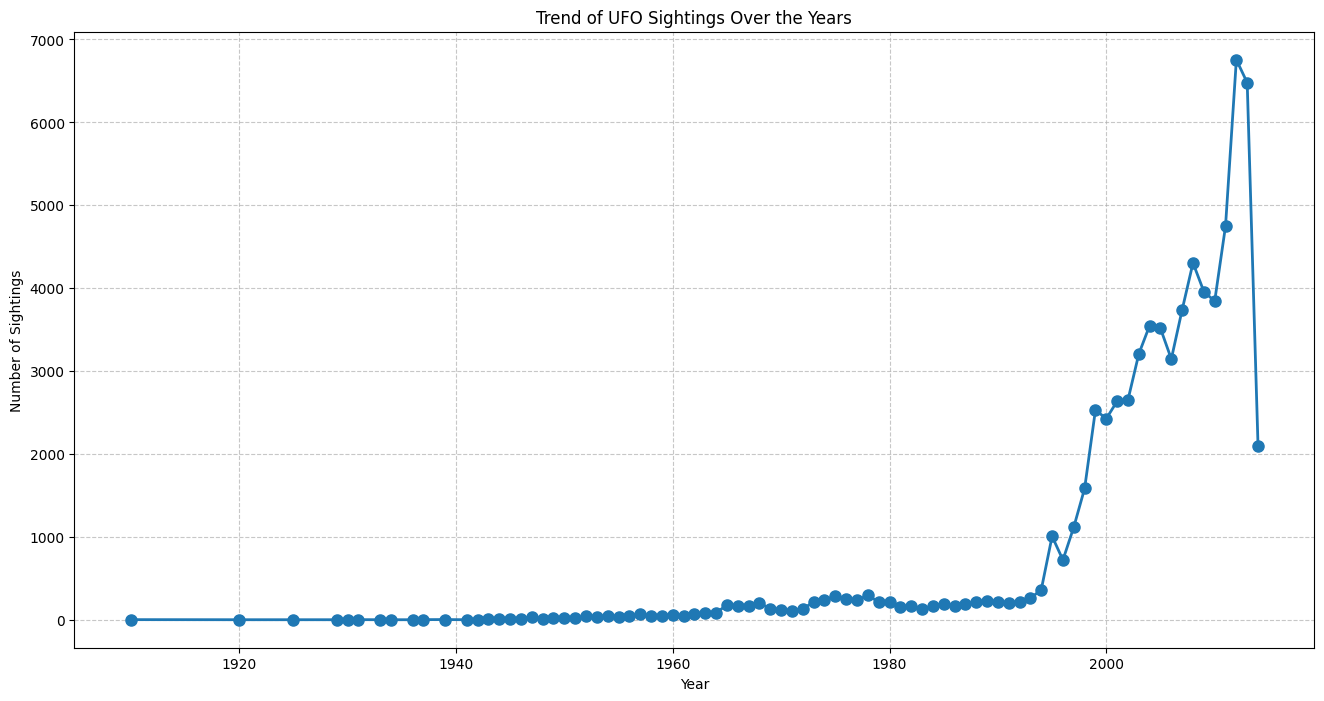

In [9]:
# Set a larger figure size for better resolution
plt.figure(figsize=(16, 8))

# Group the data by 'Year' and calculate the number of sightings in each year
yearly_sightings = df.groupby('Year').size()

# Create a line chart with a smoother curve, using a light blue color
plt.plot(yearly_sightings, marker='o', color='#1f78b4', linewidth=2, markersize=8)

# Set labels and title for better interpretation
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.title('Trend of UFO Sightings Over the Years')

# Display the line chart with a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the line chart
plt.show()

The graph depicting UFO sightings over the years reveals intriguing patterns in the data. Notably, there is a significant peak in sightings in the year 2012, which prompts further investigation into potential contributing factors.

One plausible explanation for the spike in 2012 could be attributed to increased accessibility for reporting sightings. It's essential to consider technological advancements and changes in reporting mechanisms during that period. The proliferation of smartphones and internet access may have made it easier for individuals to promptly report and share their UFO experiences. This heightened accessibility could account for the surge in reported sightings during this particular year.

However, it's crucial to note a subsequent decline in sightings after 2012. This drop might be associated with changes in data collection practices, potentially indicating a shift in the way UFO sightings were documented or reported. A significant factor could be the cessation of active information gathering or a data cutoff in 2014, leading to a notable decrease in recorded sightings.

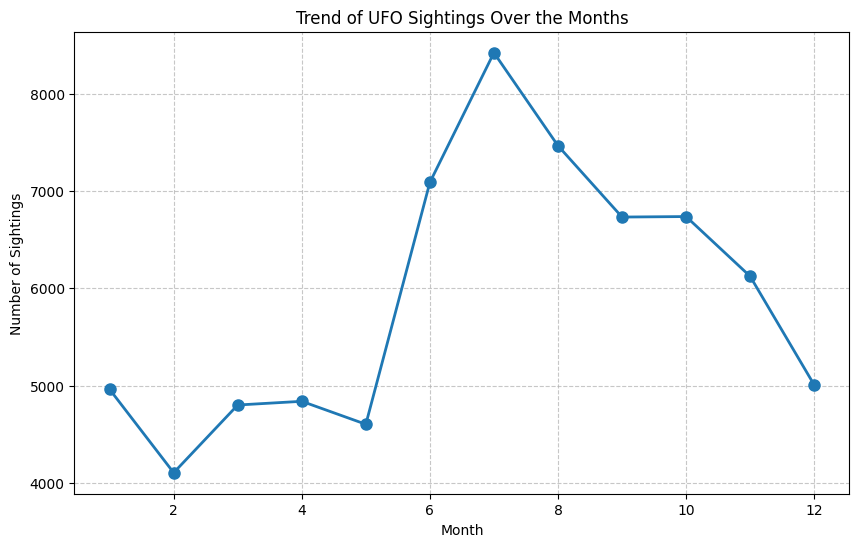

In [10]:
# Set the figure size for better visualization
plt.figure(figsize=(10, 6))

# Group the data by 'Month' and calculate the number of sightings in each month
monthly_sightings = df.groupby('Month').size()

# Create a line chart to visualize the trend of UFO sightings over the months
plt.plot(monthly_sightings, marker='o', color='#1f78b4', linewidth=2, markersize=8)

# Set labels and title for better interpretation
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.title('Trend of UFO Sightings Over the Months')

# Display a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the line chart
plt.show()

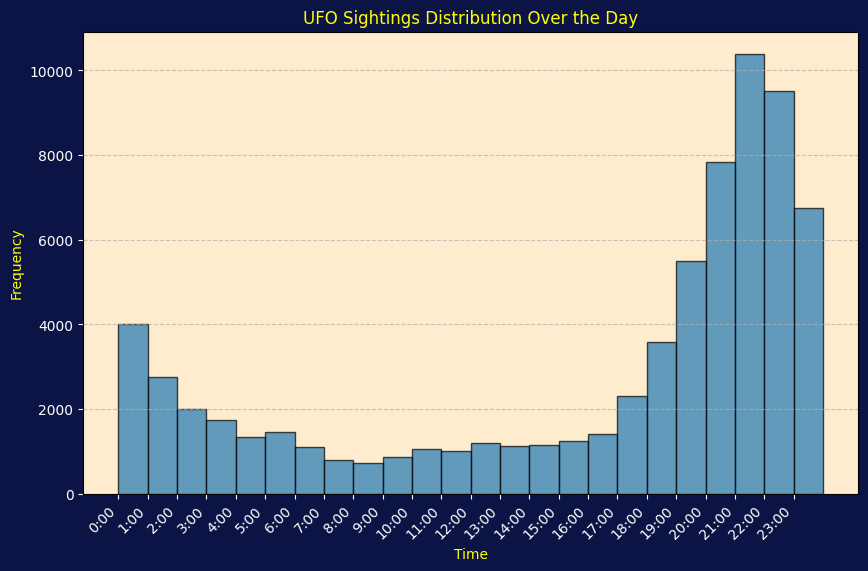

In [11]:
# Extract the hour and minute components from the 'Time' column
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute

# Create a new column 'TimeCombined' by converting hour and minute to minutes for better analysis
df['TimeCombined'] = df['Hour'] * 60 + df['Minute']

# Set the figure size for better visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Specify the bin edges to ensure 24 ticks on the x-axis
bin_edges = [hour * 60 for hour in range(25)]  # One more than the number of ticks (24 hours)

# Plot a histogram to visualize the distribution of UFO sightings throughout the day
ax.hist(df['TimeCombined'], bins=bin_edges, color='#1f78b4', alpha=0.7, edgecolor='black')

# Add title and labels for better interpretation with a night sky theme
ax.set_title('UFO Sightings Distribution Over the Day', color='yellow')
ax.set_xlabel('Time', color='yellow')
ax.set_ylabel('Frequency', color='yellow')

# Set x-axis ticks and labels to represent hours
ax.set_xticks(range(0, 24 * 60, 60))
ax.set_xticklabels([f'{hour}:00' for hour in range(24)], rotation=45, ha='right')

# Remove the grid background for a cleaner appearance
ax.grid(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Set the background color of the entire figure to represent the night sky
fig.patch.set_facecolor('#0c1445')
ax.set_facecolor('#ffebcd')

# Change the color of the x-axis and y-axis labels
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Display the histogram
plt.show()



The chart clearly illustrates a consistent pattern of increased UFO sightings during nighttime hours. This aligns with the common narrative of UFO reports, often describing unidentified objects observed in the night sky. The visual representation strongly suggests a concentration of sightings during darker periods, emphasizing the prevalence of these occurrences during the night.

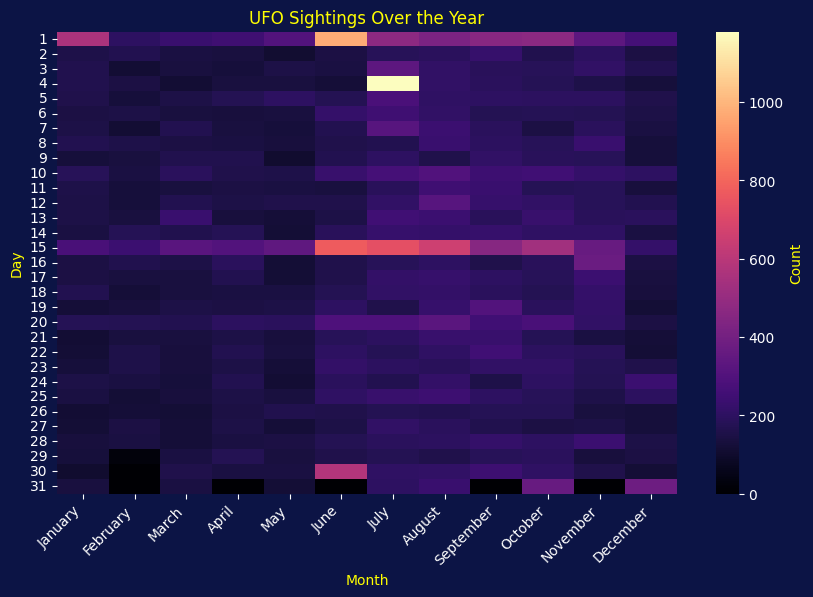

In [12]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the heatmap using Seaborn and fill missing values with 0
heatmap_data = df.groupby(['Day', 'Month']).size().unstack().fillna(0)
heatmap = sns.heatmap(heatmap_data, cmap='magma', annot=False, cbar_kws={'label': 'Count'})

# Set labels for the x and y axes, and add a title to the heatmap
ax.set_xlabel('Month', color='yellow')  # X-axis label with yellow color
ax.set_ylabel('Day', color='yellow')    # Y-axis label with yellow color
ax.set_title('UFO Sightings Over the Year', color='yellow')  # Title with yellow color

# Set the background color of the entire figure to a dark shade
fig.patch.set_facecolor('#0c1445')

# Set the color of the x-axis and y-axis ticks to yellow
ax.tick_params(axis='x', colors='white')  # X-axis tick color is white
ax.tick_params(axis='y', colors='white')  # Y-axis tick color is white

# Change the color of the colorbar label to yellow
cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.label.set_color('yellow')

# Set the color of the colorbar ticks to white
cbar.ax.tick_params(axis='y', colors='white')

# Get the month names corresponding to the columns
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Set x-axis tick labels to month names and rotate them by 45 degrees
ax.set_xticklabels(month_names, rotation=45, ha='right')

# Display the heatmap
plt.show()


The analysis of UFO sighting data reveals distinct patterns. High activity months, like June and July, show elevated sightings due to favorable weather. December sees an uptick, possibly linked to increased holiday outdoor activities. Conversely, low activity months, such as February and September, report fewer sightings, likely influenced by harsh weather and transitional conditions.

Major holidays like New Year's Eve and Independence Day (4th of July) often coincide with increased UFO sightings, particularly in areas where fireworks are a common part of celebrations. The dazzling displays of fireworks can create unfamiliar visual phenomena, potentially leading to more reported sightings. The combination of vibrant lights, unique patterns, and heightened outdoor activity during these festivities may contribute to a higher likelihood of people noticing and reporting UFOs. Cultural events and holiday activities introduce distinctive environmental factors that influence public perception of celestial events and contribute to the observed surge in sightings.

The observed higher number of UFO sightings at the beginning of the month may be influenced by various factors related to data reporting, human behavior, and awareness. There could be a systematic bias in reporting, where people are more likely to submit sightings early in the month, possibly influenced by reporting systems, data collection practices, or deadlines. Monthly reporting cycles, especially within government agencies or organizations, may contribute to a clustering of sightings in the initial days if data is released or updated at the beginning of each month.

#### Maps

In [13]:
# Create a copy of the DataFrame for mapping purposes
maps_df = df.copy()

# Define state abbreviations mapping
state_mapping = {
    'Alabama': 'al',
    'Alaska': 'ak',
    'Arizona': 'az',
    'Arkansas': 'ar',
    'California': 'ca',
    'Colorado': 'co',
    'Connecticut': 'ct',
    'Delaware': 'de',
    'Florida': 'fl',
    'Georgia': 'ga',
    'Hawaii': 'hi',
    'Idaho': 'id',
    'Illinois': 'il',
    'Indiana': 'in',
    'Iowa': 'ia',
    'Kansas': 'ks',
    'Kentucky': 'ky',
    'Louisiana': 'la',
    'Maine': 'me',
    'Maryland': 'md',
    'Massachusetts': 'ma',
    'Michigan': 'mi',
    'Minnesota': 'mn',
    'Mississippi': 'ms',
    'Missouri': 'mo',
    'Montana': 'mt',
    'Nebraska': 'ne',
    'Nevada': 'nv',
    'New Hampshire': 'nh',
    'New Jersey': 'nj',
    'New Mexico': 'nm',
    'New York': 'ny',
    'North Carolina': 'nc',
    'North Dakota': 'nd',
    'Ohio': 'oh',
    'Oklahoma': 'ok',
    'Oregon': 'or',
    'Pennsylvania': 'pa',
    'Rhode Island': 'ri',
    'South Carolina': 'sc',
    'South Dakota': 'sd',
    'Tennessee': 'tn',
    'Texas': 'tx',
    'Utah': 'ut',
    'Vermont': 'vt',
    'Virginia': 'va',
    'Washington': 'wa',
    'West Virginia': 'wv',
    'Wisconsin': 'wi',
    'Wyoming': 'wy',
}

# Adjust longitude and map state abbreviations
maps_df['longitude'] = df['longitude'].apply(lambda x: x - 360 if x > 0 else x)
maps_df['state'] = maps_df['state'].map(state_mapping)

In [14]:
# Create a base map centered at an initial location
map_center = [maps_df['latitude'].mean(), maps_df['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=3)

# Convert latitude and longitude columns to list of tuples
heat_data = [(row['latitude'], row['longitude']) for index, row in maps_df.iterrows()]

# Add a HeatMap layer to the map
HeatMap(heat_data).add_to(mymap)

# Save the map to an HTML file or display it
display(mymap)

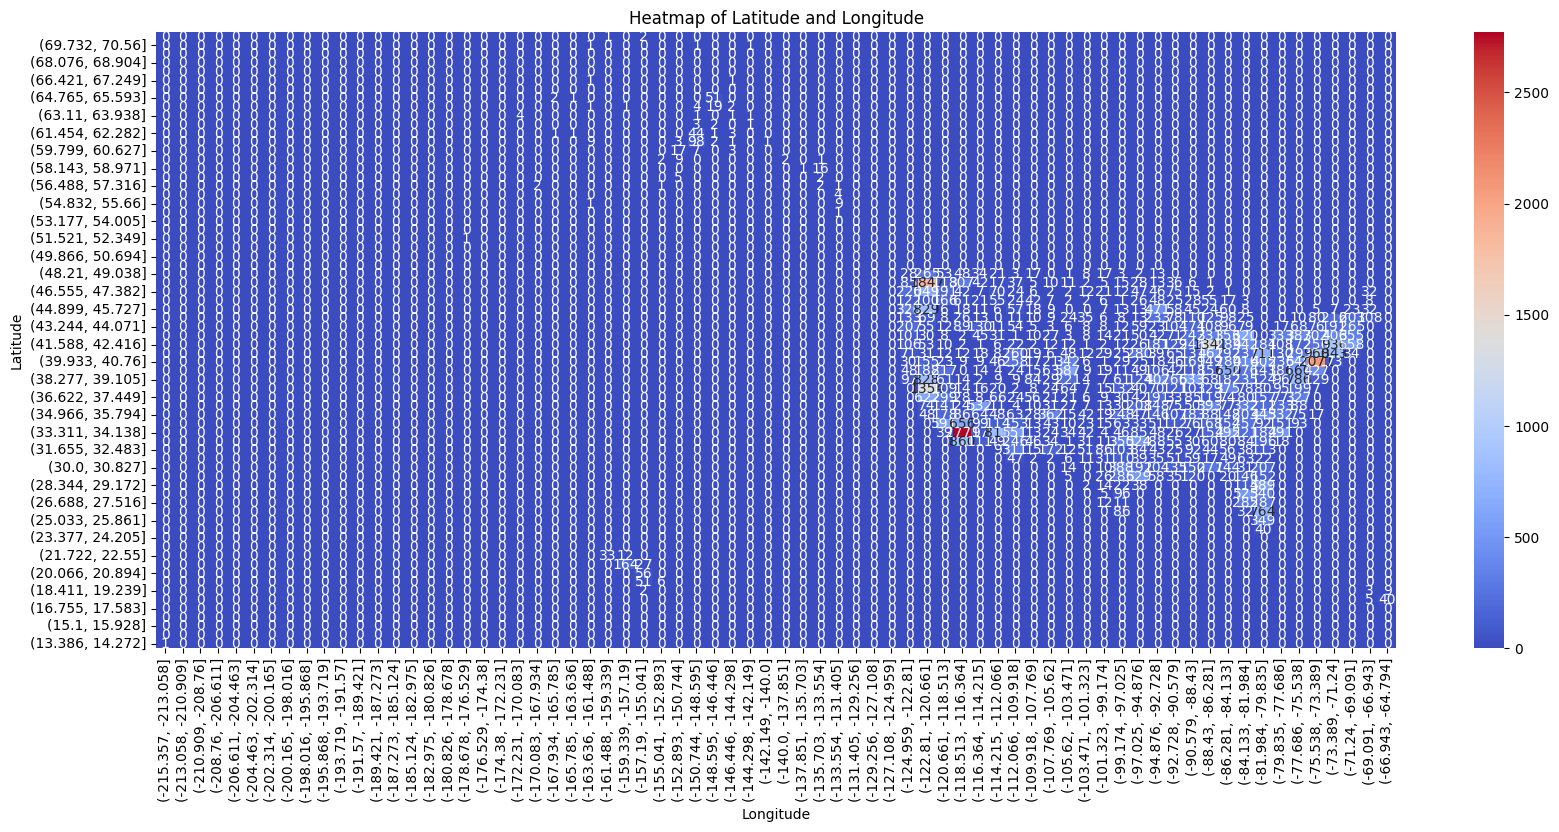

In [15]:
# Create a copy of the DataFrame for mapping purposes
maps_df = df.copy()

# Adjust longitude values to handle locations east of the prime meridian
maps_df['longitude'] = df['longitude'].apply(lambda x: x - 360 if x > 0 else x)

# Create bins for latitude and longitude
maps_df['long_bin'] = pd.cut(maps_df['longitude'], bins=70)
maps_df['lat_bin'] = pd.cut(maps_df['latitude'], bins=70)

# Group data based on latitude and longitude bins, create a heatmap dataset
heatmap_data = maps_df.groupby(['lat_bin', 'long_bin']).size().unstack(fill_value=0)

# Plot a heatmap to visualize the distribution of UFO sightings on a map
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='g')

# Invert the y-axis to align with map coordinates
plt.gca().invert_yaxis()

# Set labels and title for better interpretation
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Latitude and Longitude')

# Display the heatmap
plt.show()

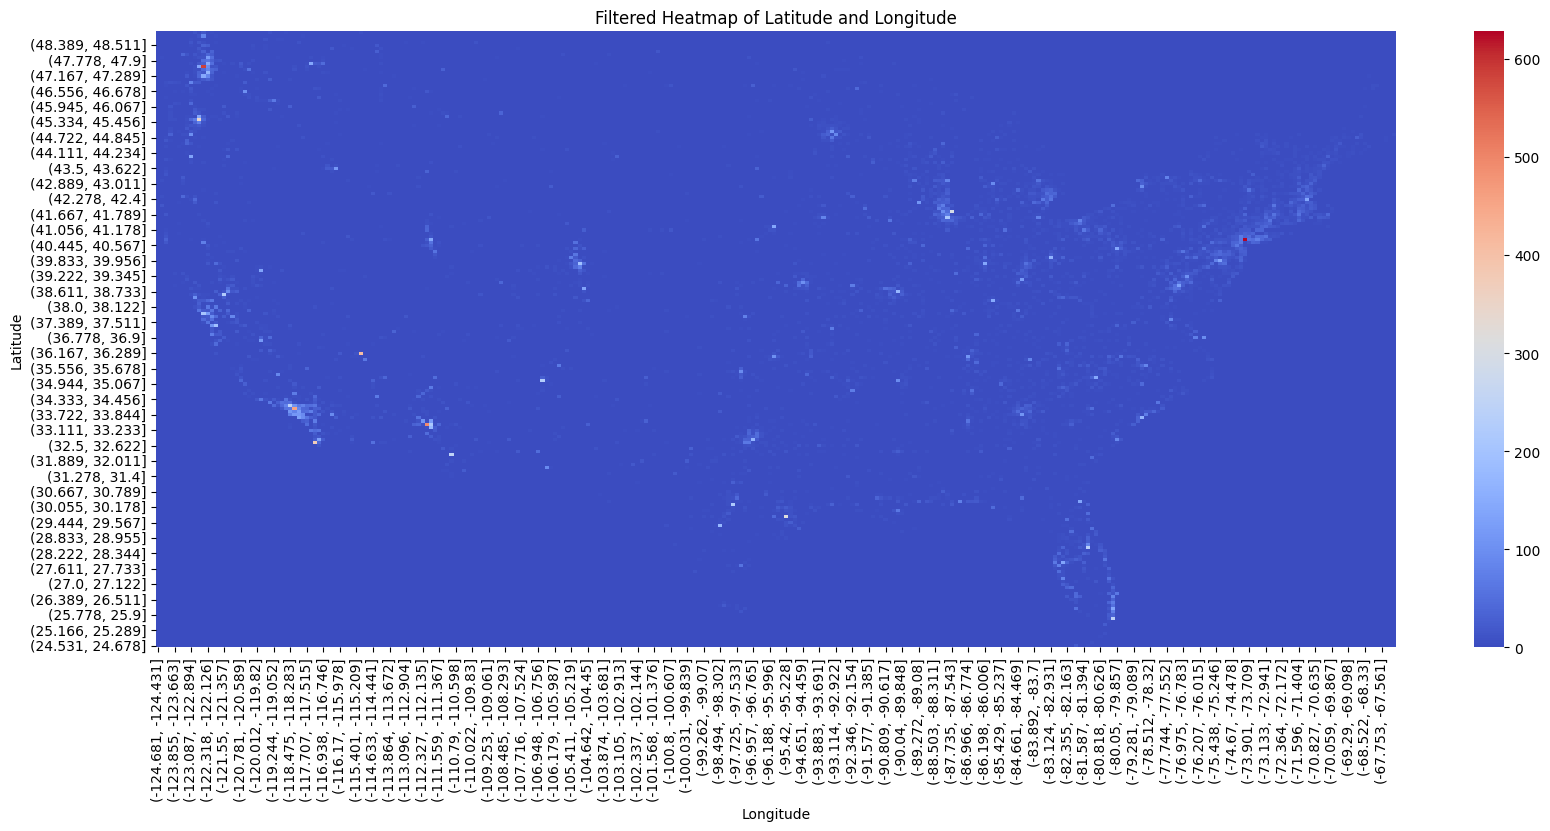

In [16]:
# Create a copy of the DataFrame for mapping purposes
maps_df = df.copy()

# Adjust longitude values to handle locations east of the prime meridian
maps_df['longitude'] = df['longitude'].apply(lambda x: x - 360 if x > 0 else x)

# Filter data based on specific geographic coordinates
maps_df = maps_df[(maps_df['longitude'] >= -130) & (maps_df['longitude'] <= -65)]
maps_df = maps_df[(maps_df['latitude'] >= 20) & (maps_df['latitude'] <= 50)]

# Create bins for latitude and longitude
maps_df['long_bin'] = pd.cut(maps_df['longitude'], bins=300)
maps_df['lat_bin'] = pd.cut(maps_df['latitude'], bins=200)

# Group data based on latitude and longitude bins, create a heatmap dataset
heatmap_data = maps_df.groupby(['lat_bin', 'long_bin']).size().unstack(fill_value=0)

# Plot a heatmap to visualize the filtered distribution of UFO sightings on a map
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt='g')

# Invert the y-axis to align with map coordinates
plt.gca().invert_yaxis()

# Set labels and title for better interpretation
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Filtered Heatmap of Latitude and Longitude')

# Display the heatmap
plt.show()


In analyzing the UFO sighting heatmap, it's intriguing to note that the distribution of sightings almost resembles the geographical outline of the United States. The concentrations of heat points seem to align with the contours of the country

<ipython-input-17-14f46872e326>:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', pad=0.02, shrink=0.7)


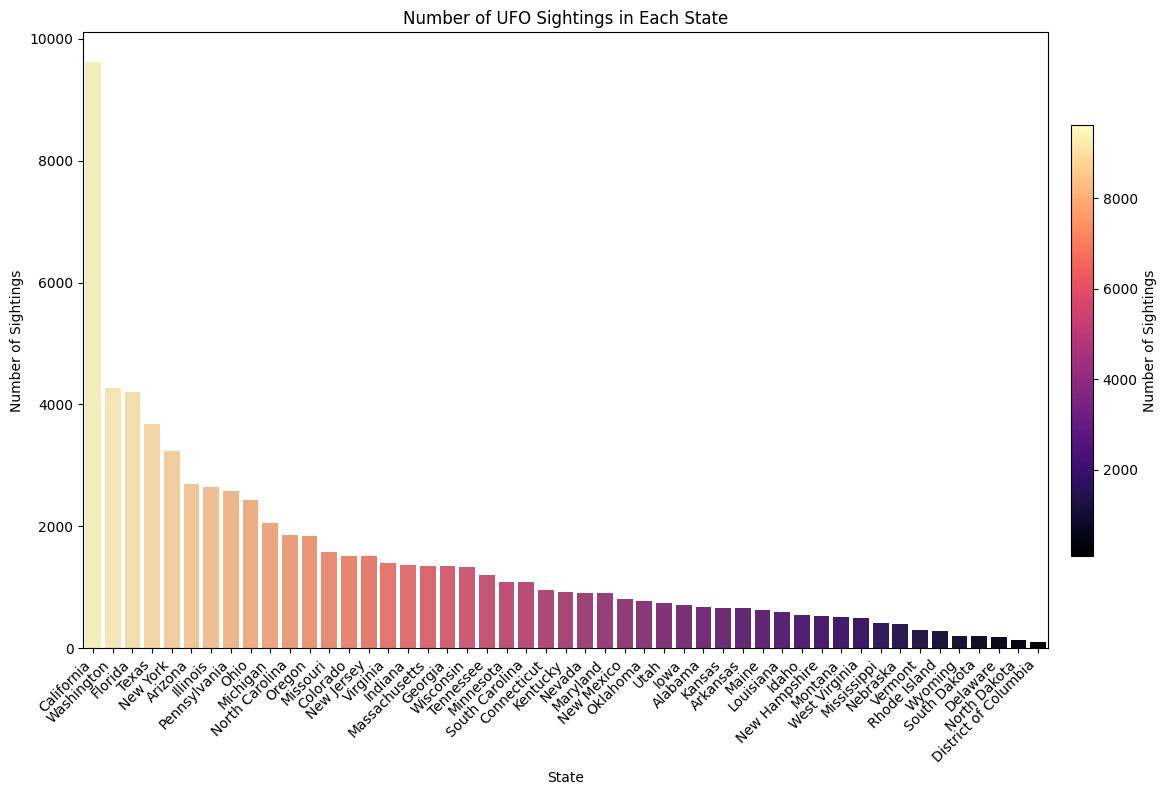

In [17]:
# Assuming 'state' column is present in your DataFrame
sightings_by_state = maps_df['state'].value_counts().to_dict()

# Assign colors using 'magma' colormap
colors = sns.color_palette('magma', len(sightings_by_state))

# Reverse the order of colors
colors.reverse()

# Create a color dictionary with state names as keys and corresponding reversed colors
color_dict = dict(zip(sightings_by_state.keys(), colors))

# If you want to visualize the reversed colors in a bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x=list(sightings_by_state.keys()), y=list(sightings_by_state.values()), palette=colors)

plt.xlabel('State')
plt.ylabel('Number of Sightings')
plt.title('Number of UFO Sightings in Each State')

plt.xticks(rotation=45, ha='right')  # Rotate state names for better readability

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=min(sightings_by_state.values()), vmax=max(sightings_by_state.values())))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', pad=0.02, shrink=0.7)
cbar.set_label('Number of Sightings')

plt.show()


## Goal 2

### Preprocessing

#### Extra for preprocessing

In [18]:
# Create a dictionary mapping state abbreviations to full names
state_mapping = {
    'tx': 'Texas',
    'hi': 'Hawaii',
    'tn': 'Tennessee',
    'ct': 'Connecticut',
    'al': 'Alabama',
    'fl': 'Florida',
    'ca': 'California',
    'nc': 'North Carolina',
    'ny': 'New York',
    'ky': 'Kentucky',
    'mi': 'Michigan',
    'ma': 'Massachusetts',
    'ks': 'Kansas',
    'sc': 'South Carolina',
    'wa': 'Washington',
    'co': 'Colorado',
    'nh': 'New Hampshire',
    'wi': 'Wisconsin',
    'me': 'Maine',
    'ga': 'Georgia',
    'pa': 'Pennsylvania',
    'il': 'Illinois',
    'ar': 'Arkansas',
    'mo': 'Missouri',
    'oh': 'Ohio',
    'in': 'Indiana',
    'az': 'Arizona',
    'mn': 'Minnesota',
    'nv': 'Nevada',
    'ne': 'Nebraska',
    'or': 'Oregon',
    'ia': 'Iowa',
    'va': 'Virginia',
    'id': 'Idaho',
    'nm': 'New Mexico',
    'nj': 'New Jersey',
    'wv': 'West Virginia',
    'ok': 'Oklahoma',
    'ak': 'Alaska',
    'ri': 'Rhode Island',
    'vt': 'Vermont',
    'la': 'Louisiana',
    'nd': 'North Dakota',
    'pr': 'Puerto Rico',
    'ms': 'Mississippi',
    'ut': 'Utah',
    'md': 'Maryland',
    'mt': 'Montana',
    'wy': 'Wyoming',
    'sd': 'South Dakota',
    'de': 'Delaware',
    'dc': 'District of Columbia'
}

#### Dataset 1

In [19]:
# Make a copy of the original dataset
df1 = dataset_1.copy()

# Drop unnecessary columns
out = ['shape', 'duration (seconds)','duration (hours/min)', 'comments', 'date posted']
df1 = df1.drop(columns=out)

# Drop rows with NaN values
df1 = df1.dropna()

# Convert 'datetime' column to datetime format
df1['datetime'] = pd.to_datetime(df1['datetime'], format='%m/%d/%Y %H:%M', errors='coerce')

# Drop rows with NaT values in 'datetime' column
df1 = df1.dropna(subset=['datetime'])

# Extract 'Day', 'Month', and 'Hour' from 'datetime' column
df1['Day'] = df1['datetime'].dt.day.astype(int)
df1['Month'] = df1['datetime'].dt.month.astype(int)
df1['Hour'] = df1['datetime'].dt.hour.astype(int)

# Drop 'datetime' column as we have extracted the necessary information
df1 = df1.drop('datetime', axis=1)

# Filter rows where 'country' is 'us'
df1 = df1[df1['country'] == 'us']

# Replace 'us' with 'United States' in 'country' column
df1['country'] = df1['country'].replace('us', 'United States')

# Drop 'country' column as it's the same for all rows now
df1 = df1.drop('country', axis=1)

# Capitalize the first letter of each word in 'city' column
df1['City'] = df1['city'].apply(lambda x: x.title())

# Map state abbreviations to full names using the dictionary
df1['State'] = df1['state'].map(state_mapping)

# Rename 'latitude' and 'longitude' columns to 'Latitude' and 'Longitude'
df1 = df1.rename(columns={'latitude': 'Latitude', 'longitude': 'Longitude'})

# Define the desired order of columns
desired_order = ['Day', "Month", 'Hour', 'State', 'City', 'Latitude', 'Longitude']

# Reorder the columns in the DataFrame
df1 = df1[desired_order]

<ipython-input-19-14b3979cdb76>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Day'] = df1['datetime'].dt.day.astype(int)
<ipython-input-19-14b3979cdb76>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Month'] = df1['datetime'].dt.month.astype(int)
<ipython-input-19-14b3979cdb76>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [20]:
df1.head()
print(df1.shape)

(69496, 7)


#### Dataset 2

In [21]:
# Make a copy of the original dataset
df2 = dataset_2.copy()

# Drop unnecessary columns
out = ["Unnamed: 0", "Date_time", "Year", "Country_Code", "UFO_shape",	"length_of_encounter_seconds",	"Encounter_Duration",	"Description"]
df2 = df2.drop(columns=out)

# Convert 'date_documented' column to datetime format and extract 'Day'
df2['Day'] = pd.to_datetime(df2['date_documented']).dt.day

# Drop 'date_documented' column as we have extracted the necessary information
df2 = df2.drop('date_documented', axis=1)

# Filter rows where 'Country' is 'United States'
df2 = df2[df2['Country'] == 'United States']

# Drop 'Country' column as it's the same for all rows now
df2 = df2.drop('Country', axis=1)

# Drop 'Season' column as it's not needed for the analysis
df2 = df2.drop('Season', axis=1)

# Rename 'Region', 'Locale', 'latitude', and 'longitude' columns to 'State', 'City', 'Latitude', and 'Longitude' respectively
df2 = df2.rename(columns={'Region': 'State', 'Locale': 'City', 'latitude': 'Latitude', 'longitude': 'Longitude'})

# Drop rows with NaN values
df2 = df2.dropna()

# Define the desired order of columns
desired_order = ['Day', "Month", 'Hour', 'State', 'City', 'Latitude', 'Longitude']

# Reorder the columns in the DataFrame
df2 = df2[desired_order]

In [22]:
df2.head()
# print(df2.shape)

,Day,Month,Hour,State,City,Latitude,Longitude
0,27,10,20,Texas,San Marcos,29.883056,-97.941111
1,16,10,21,Texas,Bexar County,29.384210,-98.581082
3,17,10,21,Texas,Edna,28.978333,-96.645833
4,22,10,20,Hawaii,Kaneohe,21.418056,-157.803611
5,27,10,19,Tennessee,Bristol,36.595000,-82.188889


#### Combined dataset

In [23]:
# Concatenate the two dataframes, df1 and df2
# The 'ignore_index' parameter is set to True so that the original row indices are not retained
combined_df = pd.concat([df1, df2], ignore_index=True)

# Remove duplicate rows from the combined dataframe
# This is done based on all columns
combined_df = combined_df.drop_duplicates()

# Remove rows with missing values from the combined dataframe
combined_df = combined_df.dropna()

# Convert 'Latitude' and 'Longitude' columns to numeric type
# The 'errors' parameter is set to 'coerce' which means invalid parsing will be set as NaN
combined_df['Latitude'] = pd.to_numeric(combined_df['Latitude'], errors='coerce')
combined_df['Longitude'] = pd.to_numeric(combined_df['Longitude'], errors='coerce')

In [24]:
combined_df.head()

,Day,Month,Hour,State,City,Latitude,Longitude
0,10,10,20,Texas,San Marcos,29.883056,-97.941111
1,10,10,21,Texas,Edna,28.978333,-96.645833
2,10,10,20,Hawaii,Kaneohe,21.418056,-157.803611
3,10,10,19,Tennessee,Bristol,36.595000,-82.188889
4,10,10,23,Connecticut,Norwalk,41.117500,-73.408333


In [25]:
# Get the unique values for 'Day' column
unique_day = np.sort(combined_df['Day'].unique())
print("Unique values for 'Day':", unique_day, "\n")

# Get the unique values for 'Month' column
unique_month = np.sort(combined_df['Month'].unique())
print("Unique values for 'Month':\n", unique_month, "\n")

# Get the unique values for 'Hour' column
unique_hour = np.sort(combined_df['Hour'].unique())
print("Unique values for 'Hour':\n", unique_hour, "\n")

# Get the unique values for 'State' column
unique_state = np.sort(combined_df['State'].unique())
print("Unique values for 'State':", unique_state)

# Columns 'City', 'Latitude' and 'Longitude have too many values, so finding unique values do not give us good feedback if we have some weird values

Unique values for 'Day': [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] 

Unique values for 'Month':
 [ 1  2  3  4  5  6  7  8  9 10 11 12] 

Unique values for 'Hour':
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 

Unique values for 'State': ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Guam' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas'
 'United States Virgin Islands' 'Utah' 'Vermont' 'Virginia' 'Washington'
 'West Virginia' 'Wisconsin' 'Wyoming']


I need just these columns:
* Day
* Month
* Hour
* State
* City
* Latitude - i will not use it as a target or as a feature, but I can use it to map location on a map
* Longitude - i will not use it as a target or as a feature, but I can use it to map location on a map

### Overview of most commons

#### Mapping sightnings locations

In [26]:
# Function to create a map centered at a specific location
def map_single_location(city, latitude, longitude):
    # Define the center of the map
    map_center = [latitude, longitude]

    # Create a map centered at the defined location
    my_map = folium.Map(location=map_center, zoom_start=5)

    # Add a marker at the defined location
    folium.Marker(
        location=[latitude, longitude],
        popup=city,
    ).add_to(my_map)

    # Save the map to an HTML file named after the city
    my_map.save(str(city)+".html")

# Function to create a map with multiple locations
def map_multiple_location(cities, latitudes, longitudes):
    # Define the center of the map as the mean of the latitudes and longitudes
    map_center = [latitudes.mean(), longitudes.mean()]

    # Create a map centered at the defined location
    my_map = folium.Map(location=map_center, zoom_start=5)

    # Add a marker for each city
    for i in range(len(cities)):
        folium.Marker(
            location=[latitudes[i], longitudes[i]],
            popup=cities[i],
        ).add_to(my_map)

    # Save the map to an HTML file named "all_cities.html"
    my_map.save("all_cities.html")

In [27]:
# Drop duplicate rows based on 'City' column
# The 'keep' parameter is set to 'first' which means we keep the first occurrence of each city
df_cities = combined_df.drop_duplicates(subset='City', keep='first')

# Reset the index of the DataFrame
# The 'drop' parameter is set to True which means we do not want to keep the old index
df_cities = df_cities.reset_index(drop=True)

# Convert the 'City' column to a list
cities = df_cities['City'].tolist()

# Get the 'Latitude' and 'Longitude' columns
latitudes = df_cities['Latitude']
longitudes = df_cities['Longitude']

# Call the 'map_multiple_location' function to create a map with markers at the cities
map_multiple_location(cities, latitudes, longitudes)

#### Most common values from datasets

In [28]:
# Define a function to get the most common value for a given column in a DataFrame
def get_value(df, column):
    # If the column is 'City', we want to return the most common city along with its latitude and longitude
    if column == 'City':
        # Find the most common city
        most_common_city = df[column].mode().iloc[0]

        # Get the latitude and longitude of the most common city
        lat = df[df['City'] == most_common_city]['Latitude'].iloc[0]
        lon = df[df['City'] == most_common_city]['Longitude'].iloc[0]

        # Return the most common city along with its latitude and longitude
        return [most_common_city, lat, lon]
    else:
        # For other columns, just return the most common value
        return df[column].mode().iloc[0]

# Define the columns for which we want to find the most common values
targets = ["Day", "Month", "Hour", "State", "City"]

# Initialize an empty list to store the most common values
most_commons = []

# Find and print the most common values for each target in df1
print("df1")
for target in targets:
    result = get_value(df1, target)
    print(target, result)

# Find and print the most common values for each target in df2
print("\ndf2")
for target in targets:
    result = get_value(df2, target)
    print(target, result)

# Find and print the most common values for each target in combined_df
print("\ncombined_df")
for target in targets:
    result = get_value(combined_df, target)
    most_commons.append(result)
    print(target, result)

# Get the most common city along with its latitude and longitude
city = most_commons[-1][0]
latitude = most_commons[-1][1]
longitude = most_commons[-1][2]

# Create a map centered at the most common city
map_single_location(city, latitude, longitude)

df1
Day 15
Month 7
Hour 21
State California
City ['Seattle', '47.6063889', -122.3308333]

df2
Day 12
Month 7
Hour 21
State California
City ['Los Angeles', 34.1577778, -118.6375]

combined_df
Day 12
Month 7
Hour 21
State California
City ['Los Angeles', 34.0522222, -118.2427778]


As we discovered under our Goal 1 section, the datasets overlap a lot and it shows here too with most common values. Most common mont, hour and state is the same for both datasets and overall combined datsets and dataset 2 have the same most common values. So we can say, that the most probable is to see for an example an ufo in Los Angeles, California.

### Models

#### Model 1 with chosen classifier

We tried different classiefiers and decided to keep a Gaussian Naive Bayes model because it worked fast, did not crash and had similar results with other classifiers. RandomForestClassifier, SVC and KNeighborsClassifier ran way to slow or crashed in Google Colab because they used too much RAM.

In [29]:
# Define a function to train a RandomForest model
def model1(df, features, target):
    # Initialize a LabelEncoder
    le = LabelEncoder()

    # Define the categorical features
    categorical_features = ['State', 'City']

    # Apply LabelEncoder to the categorical features
    df[categorical_features] = df[categorical_features].apply(le.fit_transform)

    # Define features X and target y
    X = df[features]
    y = df[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize a Gaussian Naive Bayes model
    model = GaussianNB(var_smoothing=1e-9)  # var_smoothing parameter is added

    # Return the model and the split data
    return model, X_train, X_test, y_train, y_test

# Define the features for each target
features = {
    "Day": ["Month",	"Hour", "State",	"City"],
    "Month": ["Day",	"Hour", "State",	"City"],
    "Hour": ["Day",	"Month",	"State",	"City"],
    "State": ["Day",	"Month",	"Hour"],
    "City": ["Day",	"Month",	"Hour", "State"],
}

# Define the targets
targets = ["Day",	"Month",	"Hour", "State",	"City"]

In [30]:
print("Day")
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model1(combined_df, features["Day"], "Day")

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(y_test, predictions))

Day
Accuracy: 0.06536933490288405


In [31]:
print("Month")
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model1(combined_df, features["Month"], "Month")

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(y_test, predictions))

Month
Accuracy: 0.12724396703943497


In [32]:
print("Hour")
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model1(combined_df, features["Hour"], "Hour")

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(y_test, predictions))

Hour
Accuracy: 0.1483225426721601


In [33]:
print("State")
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model1(combined_df, features["State"], "State")

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(y_test, predictions))

State
Accuracy: 0.13526339022954678


In [34]:
print("City")
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model1(combined_df, features["City"], "City")

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(y_test, predictions))

City
Accuracy: 0.036675985874043554


We're getting low prediction accuracy (under 15%), so it could indicate several potential issues with our dataset or model:

1. **Poor Quality of Data**: Our data might contain noise, outliers, or errors that are making it difficult for the model to learn the underlying patterns.

2. **Insufficient Data**: If our dataset is too small, the model might not have enough examples to learn from.

3. **Imbalanced Data**: If our dataset is imbalanced (i.e., one class has many more examples than another), the model might be biased towards the majority class.

4. **Irrelevant Features**: The features we're using to train the model might not be relevant to the target variable.

5. **Overfitting or Underfitting**: Our model might be too complex (overfitting) or too simple (underfitting) for the data.

6. **Incorrect Model Assumptions**: The assumptions made by the model might not hold true for our data. For example, if we're using a linear model but the relationship between the features and the target is non-linear.

7. **Need for Feature Engineering**: Creating new features from the existing ones might help improve the model's performance.

8. **Need for Hyperparameter Tuning**: The model's hyperparameters might not be set optimally for our data.

#### Model 2 with neural networks

In [35]:
# Define a function to train a Neural Network model
def model2(df, features, target):
    # Initialize a LabelEncoder
    le = LabelEncoder()

    # Define the categorical features
    categorical_features = ['State', 'City']

    # Apply LabelEncoder to the categorical features
    df[categorical_features] = df[categorical_features].apply(le.fit_transform)

    # Define features X and target y
    X = df[features]
    y = df[target]

    # Convert labels to categorical one-hot encoding
    y_labels = to_categorical(y, num_classes=max(y) + 1)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

    # Define the model
    model = Sequential()
    model.add(Dense(64, input_dim=len(X.columns), activation='relu'))  # Input layer
    model.add(Dense(64, activation='relu'))  # Hidden layer
    model.add(Dense(max(y) + 1, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Return the model and the split data
    return model, X_train, X_test, y_train, y_test

# Define the features for each target
features = {
    "Day": ["Month",	"Hour", "State",	"City"],
    "Month": ["Day",	"Hour", "State",	"City"],
    "Hour": ["Day",	"Month",	"State",	"City"],
    "State": ["Day",	"Month",	"Hour"],
    "City": ["Day",	"Month",	"Hour", "State"],
}

# Define the targets
targets = ["Day",	"Month",	"Hour", "State",	"City"]

In [36]:
print("Day")
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model2(combined_df, features["Day"], "Day")

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))

Day
Epoch 1/10
3398/3398 [==============================] - 9s 2ms/step - loss: 17.6834 - accuracy: 0.0495
Epoch 2/10
3398/3398 [==============================] - 7s 2ms/step - loss: 3.3918 - accuracy: 0.0617
Epoch 3/10
3398/3398 [==============================] - 10s 3ms/step - loss: 3.3921 - accuracy: 0.0616
Epoch 4/10
3398/3398 [==============================] - 7s 2ms/step - loss: 3.3883 - accuracy: 0.0617
Epoch 5/10
3398/3398 [==============================] - 9s 3ms/step - loss: 3.3894 - accuracy: 0.0617
Epoch 6/10
3398/3398 [==============================] - 6s 2ms/step - loss: 3.3882 - accuracy: 0.0617
Epoch 7/10
3398/3398 [==============================] - 8s 2ms/step - loss: 3.3882 - accuracy: 0.0617
Epoch 8/10
3398/3398 [==============================] - 7s 2ms/step - loss: 3.3942 - accuracy: 0.0618
Epoch 9/10
3398/3398 [==============================] - 7s 2ms/step - loss: 3.3881 - accuracy: 0.0617
Epoch 10/10
850/850 [==============================] - 1s 1ms/step
Accuracy:

In [37]:
print("Month")
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model2(combined_df, features["Month"], "Month")

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))

Month
Epoch 1/10
3398/3398 [==============================] - 9s 2ms/step - loss: 25.3318 - accuracy: 0.0888
Epoch 2/10
3398/3398 [==============================] - 6s 2ms/step - loss: 6.7249 - accuracy: 0.0929
Epoch 3/10
3398/3398 [==============================] - 9s 3ms/step - loss: 2.4675 - accuracy: 0.1153
Epoch 4/10
3398/3398 [==============================] - 7s 2ms/step - loss: 2.4635 - accuracy: 0.1160
Epoch 5/10
3398/3398 [==============================] - 9s 3ms/step - loss: 2.4661 - accuracy: 0.1160
Epoch 6/10
3398/3398 [==============================] - 7s 2ms/step - loss: 2.4627 - accuracy: 0.1160
Epoch 7/10
3398/3398 [==============================] - 8s 2ms/step - loss: 2.4627 - accuracy: 0.1159
Epoch 8/10
3398/3398 [==============================] - 8s 2ms/step - loss: 2.4730 - accuracy: 0.1160
Epoch 9/10
3398/3398 [==============================] - 7s 2ms/step - loss: 2.4626 - accuracy: 0.1160
Epoch 10/10
850/850 [==============================] - 1s 1ms/step
Accuracy

In [38]:
print("Hour")
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model2(combined_df, features["Hour"], "Hour")

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))

Hour
Epoch 1/10
3398/3398 [==============================] - 10s 3ms/step - loss: 26.9827 - accuracy: 0.0813
Epoch 2/10
3398/3398 [==============================] - 6s 2ms/step - loss: 3.9499 - accuracy: 0.1303
Epoch 3/10
3398/3398 [==============================] - 9s 3ms/step - loss: 2.8176 - accuracy: 0.1450
Epoch 4/10
3398/3398 [==============================] - 6s 2ms/step - loss: 2.8151 - accuracy: 0.1451
Epoch 5/10
3398/3398 [==============================] - 8s 2ms/step - loss: 2.8284 - accuracy: 0.1450
Epoch 6/10
3398/3398 [==============================] - 8s 2ms/step - loss: 2.8157 - accuracy: 0.1452
Epoch 7/10
3398/3398 [==============================] - 7s 2ms/step - loss: 2.8194 - accuracy: 0.1451
Epoch 8/10
3398/3398 [==============================] - 8s 2ms/step - loss: 2.8149 - accuracy: 0.1452
Epoch 9/10
3398/3398 [==============================] - 6s 2ms/step - loss: 2.8149 - accuracy: 0.1453
Epoch 10/10
850/850 [==============================] - 1s 1ms/step
Accuracy

In [39]:
print("State")
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model2(combined_df, features["State"], "State")

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))

State
Epoch 1/10
3398/3398 [==============================] - 9s 2ms/step - loss: 3.5475 - accuracy: 0.1352
Epoch 2/10
3398/3398 [==============================] - 7s 2ms/step - loss: 3.5194 - accuracy: 0.1360
Epoch 3/10
3398/3398 [==============================] - 8s 2ms/step - loss: 3.5122 - accuracy: 0.1360
Epoch 4/10
3398/3398 [==============================] - 8s 2ms/step - loss: 3.5097 - accuracy: 0.1360
Epoch 5/10
3398/3398 [==============================] - 7s 2ms/step - loss: 3.5077 - accuracy: 0.1360
Epoch 6/10
3398/3398 [==============================] - 9s 3ms/step - loss: 3.5065 - accuracy: 0.1360
Epoch 7/10
3398/3398 [==============================] - 7s 2ms/step - loss: 3.5051 - accuracy: 0.1360
Epoch 8/10
3398/3398 [==============================] - 9s 3ms/step - loss: 3.5042 - accuracy: 0.1360
Epoch 9/10
3398/3398 [==============================] - 7s 2ms/step - loss: 3.5033 - accuracy: 0.1360
Epoch 10/10
850/850 [==============================] - 1s 1ms/step
Accuracy:

In [40]:
print("City")
print("This cell takes too much Colabs runitime RAM, so it crashes.")
"""
# Train a model using the corresponding features
model, X_train, X_test, y_train, y_test = model2(combined_df, features["City"], "City")

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy:", accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))"""


City
This cell takes too much Colabs runitime RAM, so it crashes.


'\n# Train a model using the corresponding features\nmodel, X_train, X_test, y_train, y_test = model2(combined_df, features["City"], "City")\n\n# Train the model\nmodel.fit(X_train, y_train, epochs=10, batch_size=32)\n\n# Make predictions on the test set\npredictions = model.predict(X_test)\n\n# Print the accuracy of the model\nprint("Accuracy:", accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))'

This model has similar issues with model 1. If two different models, one with a traditional classifier and one with a neural network, are both having issues with accuracy, it suggests that the problem likely lies with the data or the way we're using the models, rather than the models themselves. Here are some potential issues and corresponding solutions:

1. **Data Quality**: If our data is noisy, contains outliers, or has many missing values, it can negatively impact the performance of our models. We should clean our data by handling missing values, removing duplicates, and dealing with outliers. - We tried to clean it already.

2. **Feature Selection**: The features we're using to train our models might not be relevant or informative enough to predict the target variable. We should consider using domain knowledge, correlation analysis, or feature importance techniques to select the most relevant features.

3. **Data Preprocessing**: If our continuous features are on different scales, it can cause issues with some models. We should consider standardizing or normalizing our features. For categorical features, we should ensure they are properly encoded.

4. **Model Configuration**: We might not be using the right hyperparameters for our models. We should consider using techniques like grid search or random search to find the optimal hyperparameters for our models.

5. **Insufficient Data**: If our dataset is too small, our models might not have enough examples to learn from. We should consider collecting more data.

6. **Imbalanced Dataset**: If our dataset is imbalanced, our models might be biased towards the majority class. We should consider using techniques like oversampling the minority class, undersampling the majority class, or using a suitable evaluation metric.

7. **Complexity of the Problem**: If our problem is highly complex or non-linear, simple models might not work well. In this case, we might need to use more complex models or feature engineering to capture the complexity.

## Goal 3

#### Preprocessing


In [48]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Convert set to list and get the first 50 stopwords
stopwords_used = list(stop_words)[:50]

# Initialize a CountVectorizer with the extended stopwords list
count_vect_stop = CountVectorizer(stop_words=stopwords_used)

# Initialize a TF-IDF Vectorizer with the extended stopwords list and limit the feature space to 1000
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_used, max_features=1000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# Initialize a CountVectorizer
count_vect = CountVectorizer()

# Initialize a TF-IDF Transformer
tfidf_transformer = TfidfTransformer()

In [50]:
# Create a DataFrame 'db' with columns 'label' and 'text' from the 'merged_df' DataFrame
db_shape = pd.DataFrame({'label': merged_df['UFO_shape'], 'text': merged_df['Description']}).copy()
db_shape['text'].fillna('', inplace=True)

# Initialize an empty list to store indices of rows to be removed
rows_to_remove = []

# Iterate over the 'label' column of the DataFrame
for index, text in db_shape['label'].items():
    try:
        # Attempt to unescape HTML entities in the 'label' column
        db_shape['label'][index] = html.unescape(text)
    except:
        # If an exception occurs (e.g., invalid HTML), add the index to the list of rows to be removed
        rows_to_remove.append(index)

# Drop rows with indices stored in the 'rows_to_remove' list
db_shape = db_shape.drop(rows_to_remove)

In [51]:
# Create a DataFrame 'db' with columns 'label' and 'text' from the 'merged_df' DataFrame
db_lenght = pd.DataFrame({'label': merged_df['length_of_encounter_seconds_df1'], 'text': merged_df['Description']}).copy()
db_lenght['text'].fillna('', inplace=True)

# Initialize an empty list to store indices of rows to be removed
rows_to_remove = []

# Iterate over the 'label' column of the DataFrame
for index, text in db_lenght['label'].items():
    try:
        # Attempt to unescape HTML entities in the 'label' column
        db_lenght['label'][index] = html.unescape(text)
    except:
        # If an exception occurs (e.g., invalid HTML), add the index to the list of rows to be removed
        rows_to_remove.append(index)

# Drop rows with indices stored in the 'rows_to_remove' list
db_lenght = db_lenght.drop(rows_to_remove)

In [52]:
shuffle(db_shape)
shuffle(db_lenght)

# Create a training set with the first 4000 rows of the DataFrame 'db'
trainset_shape = db_shape[:4000]
trainset_lenght = db_lenght[:4000]

# Create a test set with rows 4000 to 4499 from the DataFrame 'db'
testset_shape = db_shape[4000:4500]
testset_lenght = db_lenght[4000:4500]

###Training

In [53]:
def learn(trainset):
    # Define a Support Vector Machine (SVM) classifier with a linear kernel
    svm_classifier = SVC(kernel='linear')

    # Create a parameter grid for hyperparameter tuning
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1],
    }

    # Create a GridSearchCV object for hyperparameter tuning
    grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)

    # Fit the TF-IDF vectorizer and SVM classifier on the training data
    X_train_tfidf = tfidf_vectorizer.fit_transform(trainset['text'])
    grid_search.fit(X_train_tfidf, trainset['label'])

    # Get the best SVM model from the grid search
    best_svm_model = grid_search.best_estimator_

    return best_svm_model

In [54]:
def loaddata(corpus):
    # Define column names for the DataFrame
    columns = ['label', 'text']

    # Create an empty DataFrame with the specified columns
    data = pd.DataFrame(columns=columns)

    # Iterate over files in the specified directory and concatenate them into the DataFrame
    for f in os.listdir(os.getcwd() + "/" + corpus):
        # Read each file as a DataFrame with tab-separated values
        df = pd.read_csv(os.getcwd() + "/" + corpus + "/" + f, delimiter="\t", index_col=None, header=None, names=columns)

        # Concatenate the current DataFrame with the overall DataFrame
        data = os.P_PID.concat([data, df])

    # Reset the index of the concatenated DataFrame
    data = data.reset_index(drop=True)

    # Return the final DataFrame containing the loaded data
    return data

Could not take whole dataset in, because Google Colab could not process it all. Run into runtime errors

In [55]:
# Train model
model_length = learn(trainset_lenght)
model_shape = learn(trainset_shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'hadn', 'hasn', 'll', 'mightn', 're', 'should', 've', 'wasn', 'won', 'you'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### Predicting

In [56]:
def predict(model, sample):
    # Transform the input sample using the pre-fitted TF-IDF vectorizer
    X_test_tfidf = tfidf_vectorizer.transform([sample])

    # Use the provided model to predict the category of the transformed sample
    cat = model.predict(X_test_tfidf)

    # Return the predicted category
    return cat

In [57]:
def evaluate(model, testset):
    # Initialize a counter for correct predictions
    correct = 0

    # Iterate over rows in the testset DataFrame
    for i, row in testset.iterrows():
        # Extract the correct label and text from the current row
        rightAnswer = row['label']
        text = row['text']

        # Predict the category using the provided model and the text
        prediction = predict(model, text)

        # Check if the prediction is correct and update the counter
        if rightAnswer == prediction:
            correct += 1

    # Calculate accuracy
    accuracy = correct / len(testset)

    # Print and return the accuracy
    print("Accuracy: {0:.2%}".format(accuracy))
    return accuracy

In [58]:
def test(model, testset):
    # Evaluate the model on the test set and get the accuracy
    accuracy = evaluate(model, testset)

    # Return the accuracy for further analysis or reporting
    return accuracy


In [59]:
# Predict
test(model_length, trainset_lenght)

Accuracy: 7.72%


0.07725

In [60]:
#Predict
test(model_shape, testset_shape)


Accuracy: 43.20%


0.432

### Most common values from datasets

In [61]:
# Assuming 'best_svm_model' and 'tfidf_vectorizer' are already defined and trained

# Vectorize your input
input_text = "Over Harbor Haven's coastal expanse, a saucer-shaped UFO glides soundlessly. Bathed in an eerie blue glow, it hovers briefly, then disappears into the horizon, leaving witnesses captivated and sparking townwide intrigue. Authorities are silent on the unexplained celestial visitation."

X_input_tfidf = tfidf_vectorizer.transform([input_text])

# Make a prediction
prediction_length = model_length.predict(X_input_tfidf)

prediction_shape = model_shape.predict(X_input_tfidf)

# Print the result
print("Predicted length:", prediction_length[0])

print("Predicted shape:", prediction_shape[0])


Predicted length: 300
Predicted shape: disk


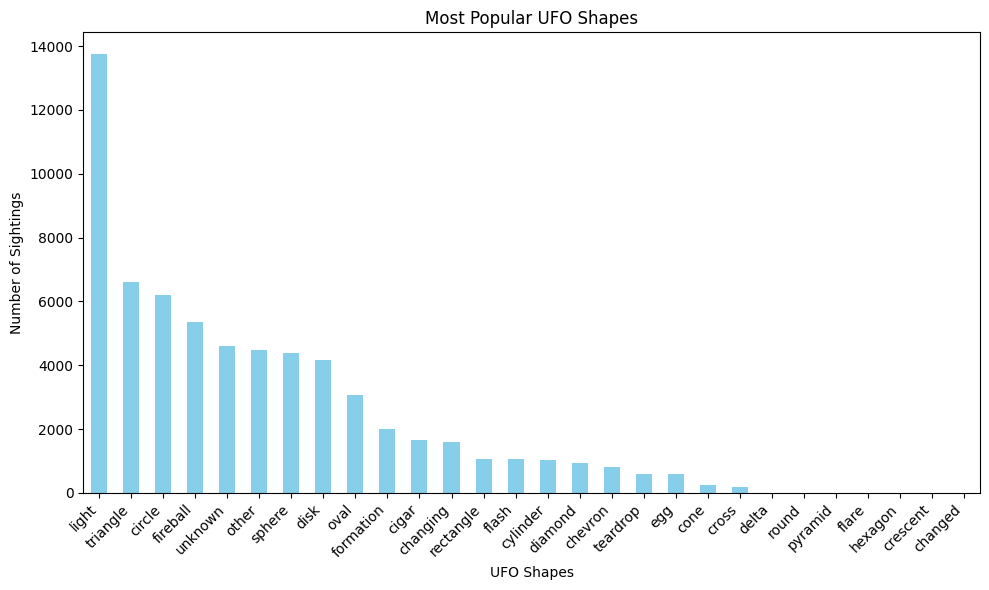

In [62]:
shape_counts = db_shape['label'].value_counts()

# Select the top 10 most popular shapes for the plot
top_shapes = shape_counts

# Plot the bar chart
plt.figure(figsize=(10, 6))
top_shapes.plot(kind='bar', color='skyblue')
plt.title('Most Popular UFO Shapes')
plt.xlabel('UFO Shapes')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

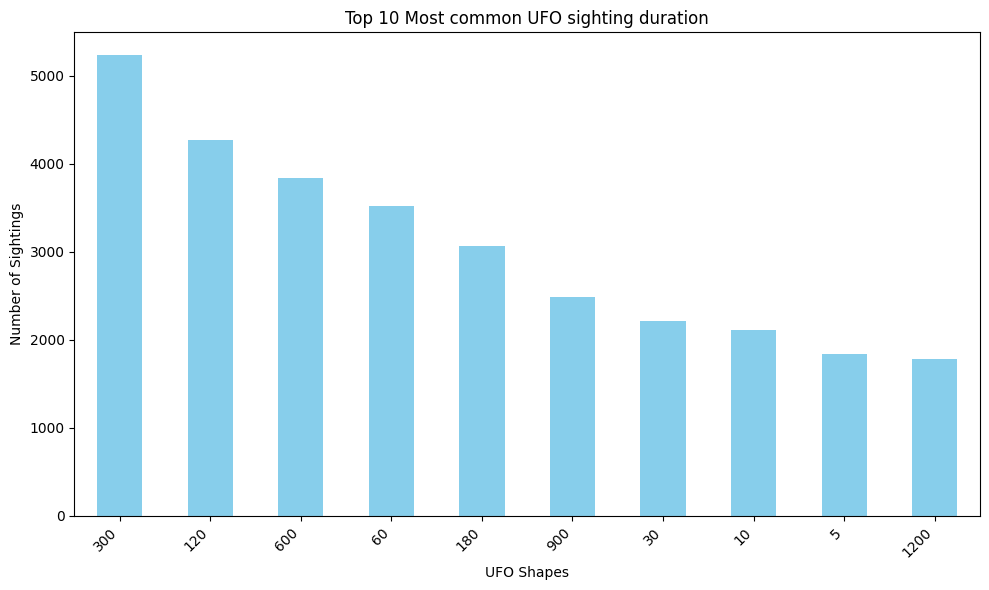

In [63]:
shape_counts = db_lenght['label'].value_counts()

# Select the top 10 most popular shapes for the plot
top_shapes = shape_counts.head(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
top_shapes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most common UFO sighting duration')
plt.xlabel('UFO Shapes')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()